# Find qubit relaxation rate using Qiskit

### Authenticate yourself for remote access to IBM Q devices

In [1]:
# authenticate yourself for remote access
from qiskit import *
IBMQ.load_accounts()

In [3]:
IBMQ.backends()

[<IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmqx5') from IBMQ()>,
 <IBMQBackend('ibmqx2') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ()>,
 <IBMQBackend('ibmq_20_tokyo') from IBMQ(ibm-q-internal, development, qiskit-core)>,
 <IBMQBackend('ibmq_qasm_simulator') from IBMQ(ibm-q-internal, development, qiskit-core)>]

### Select device and qubit to measure

In [4]:
# select device and qubit to measure T1 on
device = IBMQ.get_backend('ibmq_16_melbourne') # the device to run on
qubit = 1

In [5]:
device.status()

{'backend_name': 'ibmq_16_melbourne',
 'backend_version': '0.7.0',
 'operational': True,
 'pending_jobs': 2,
 'status_msg': ''}

### Read the qubit relaxation rate from latest calibration

In [6]:
# what we should expect to see
params = device.properties()['qubits'][qubit]
str(params['T1']['value']) +' ' + params['T1']['unit']

'64.3 µs'

### Build benchmarking circuits

In [7]:
# set up registers
from qiskit import QuantumRegister, ClassicalRegister
qr = QuantumRegister(5)
cr = ClassicalRegister(5)

In [8]:
# build the quantum circuits
from qiskit import QuantumCircuit

# create varying length circuits
steps = 20
id_gates_per_step = 80
circuits = []
for i in range(steps):
    qc = QuantumCircuit(qr, cr, name=str(i))
    qc.x(qr[qubit])
    # pad identity (wait) gates
    for j in range(id_gates_per_step*i):
        qc.barrier(qr[qubit])
        qc.iden(qr[qubit])
    qc.measure(qr[qubit], cr[qubit])
    circuits.append(qc)

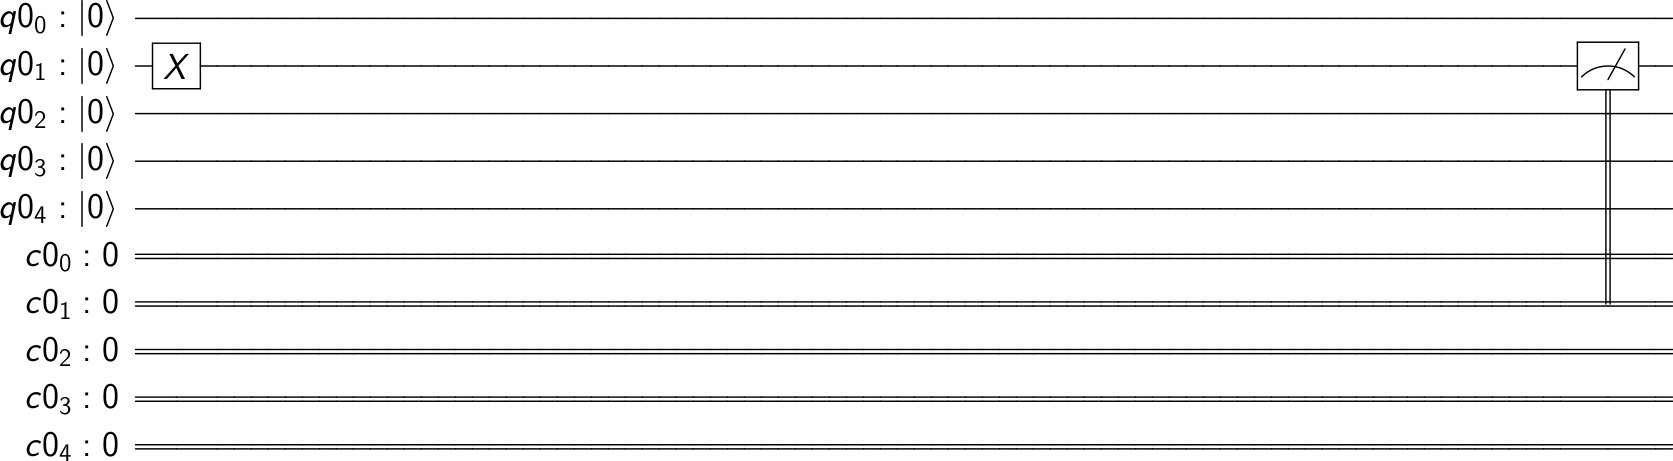

In [9]:
%matplotlib inline
from qiskit.tools.visualization import circuit_drawer
circuit_drawer(circuits[1], output='latex', style={'plotbarrier': False})

### Send the batch of circuits for execution

In [10]:
from qiskit.wrapper.jupyter import *

In [11]:
%%qiskit_job_status
shots = 1024
t1_job = execute(circuits, backend=device, shots=shots)

A Jupyter Widget

### Analyze the result

In [12]:
import numpy as np
from scipy.optimize import curve_fit
from qiskit.tools.qcvv.fitters import exp_fit_fun, osc_fit_fun, plot_coherence

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


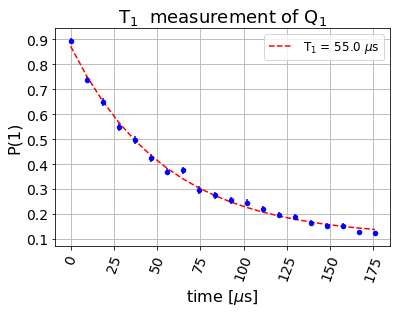

T1: 54.74 µs ± 2.53 µs


In [13]:
# arrange the result data from the run
result_t1 = t1_job.result()

# get the keys representing ground and excited states ['00000', '00010']
keys_0_1 = list(result_t1.get_counts(circuits[0]).keys())

qubit_params = device.properties()['qubits'][qubit]
pulse_length = qubit_params['gateTime']['value']
buffer_length = qubit_params['buffer']['value']
tot_length = buffer_length + pulse_length
time_per_step = id_gates_per_step * tot_length

# calculate the time steps in microseconds
plot_factor = 1
unit = params['gateTime']['unit']
if unit.find('ns') > -1:
    plot_factor = 1000
    punit = '$\\mu$s'

xvals = time_per_step * np.linspace(0, len(circuits), len(circuits)) / plot_factor 

# get the data in terms of counts for the excited state
# normalized to the total number of counts
data = np.zeros(len(circuits))
sigma_data = np.zeros(len(circuits))
for ii, circuit in enumerate(circuits):
    data[ii] = float(result_t1.get_counts(circuit)[keys_0_1[1]]) / shots
    sigma_data[ii] = np.sqrt(data[ii] * (1-data[ii])) / np.sqrt(shots)

# fit the data to an exponential    
fitT1, fcov = curve_fit(exp_fit_fun, xvals, data, bounds=([-1, 2, 0], [1., 500, 1])) 
ferr = np.sqrt(np.diag(fcov))

plot_coherence(xvals, data, sigma_data, fitT1, exp_fit_fun, punit, 'T$_1$ ', qubit)

print("T1: " + str(round(fitT1[1],2))+ " µs" + u" \u00B1 " + str(round(ferr[1],2)) + ' µs')